In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import time
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision
from collections import OrderedDict
from torch.autograd import Variable
from PIL import Image
from torch.optim import lr_scheduler
import copy
import json
import os
import shutil
from os.path import exists

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

CUDA is available!  Training on GPU ...
cuda:0


In [2]:
torch.cuda.set_device(1)
torch.__version__

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')


#Check GPU support, please do activate GPU
print(torch.cuda.current_device())
print(torch.cuda.is_available())
torch.cuda.get_device_name(torch.cuda.current_device())

Using device: cuda
NVIDIA GeForce GTX 1080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
1
True


'NVIDIA GeForce GTX 1080 Ti'

In [3]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [4]:
# Number of classes in the dataset
num_classes = 39

# Number of epochs to train for
num_epochs = 10

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

## Initialize Model

In [5]:
def final_classifier(num_ftrs,num_classes):
  return nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(num_ftrs, 512)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(512, num_classes)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet152":
        """ Resnet152
        """
        model_ft = models.resnet152(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        print(num_ftrs)
        model_ft.fc = final_classifier(num_ftrs,num_classes)
        input_size = 224
    
    elif model_name == "resnet18":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        print(num_ftrs)
        model_ft.fc = final_classifier(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        print(num_ftrs)
        model_ft.classifier[6] = final_classifier(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        print(num_ftrs)
        model_ft.classifier[6] = final_classifier(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = 512
        print(num_ftrs)
        model_ft.classifier[1] = final_classifier(num_ftrs,num_classes)
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        print(num_ftrs)
        model_ft.classifier = final_classifier(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        print(num_ftrs)
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        print(num_ftrs)
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

In [6]:
def load_checkpoint(filepath,model_to_load):
    checkpoint = torch.load(filepath)
    model,initial_size = initialize_model(model_to_load,num_classes,feature_extract,use_pretrained=True)
    
    model.load_state_dict(checkpoint)
    model.to(device)
    
    return model, checkpoint

In [7]:
# Load Plant Village trained model and get index to class mapping
model_name = "densenet"
model, class_to_idx = load_checkpoint('/home/SharedData/Siddharth/models/plantvillage_full_'+model_name+'.pt',model_name)
idx_to_class = { v : k for k,v in class_to_idx.items()}

model = model.to(device=device)

1024


In [ ]:
import glob
import shutil
from numpy import random

folders = glob.glob("/home/SharedData/Siddharth/images/images/*")
for folder in folders:
    files = glob.glob(os.path.join(folder, "*"))
    dest = os.path.basename(folder)
    length = len(files)
    random.shuffle(files)
    for i, filename in enumerate(files):
        # the data is split into 70:30 ratio between training and validation
        if(i < length*0.7):
            shutil.copy(filename, os.path.join("/home/SharedData/Siddharth/dataset/multi/train", dest))
            # print(filename, os.path.join("/content/train", dest))
        else:
            shutil.copy(filename, os.path.join("/home/SharedData/Siddharth/dataset/multi/val", dest))
            # print(filename, os.path.join("/content/val", dest))

In [8]:
#Organizing the dataset
data_dir = '/home/SharedData/Siddharth/dataset/multi'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/val'
nThreads = 4
batch_size = 16
use_gpu = torch.cuda.is_available()

# Define your transforms for the training and validation sets
# Data augmentation and normalization for training
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [9]:
from torchsampler import ImbalancedDatasetSampler

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x])for x in ['train', 'val']}

# Using the image datasets and the trainforms, define the dataloaders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],sampler=ImbalancedDatasetSampler(image_datasets[x]), batch_size=batch_size,num_workers=2)for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

In [10]:
print(class_names)

['Basal rot', 'Bulb rot seed crop', 'Damping off disease', 'Healthy']


In [11]:
model.classifier.fc2 = nn.Linear(512, len(class_names))

In [12]:
print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [27]:
#Function to train the model
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(1, num_epochs+1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                # zero the parameter gradients 
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        scheduler.step()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best valid accuracy: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [28]:
# Train a model with a pre-trained network
num_epochs = 10
if use_gpu:
    print ("Using GPU: "+ str(use_gpu))
    model = model.cuda()

# NLLLoss because our output is LogSoftmax
criterion = nn.NLLLoss()

params_to_update = model.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Adam optimizer with a learning rate
optimizer = optim.Adam(params_to_update, lr=0.001)
# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs)

Using GPU: True
Params to learn:
	 classifier.fc1.weight
	 classifier.fc1.bias
	 classifier.fc2.weight
	 classifier.fc2.bias
Epoch 1/10
----------
train Loss: 0.9237 Acc: 0.6227
val Loss: 1.0377 Acc: 0.6143
Epoch 2/10
----------
train Loss: 0.7494 Acc: 0.7221
val Loss: 0.7571 Acc: 0.7429
Epoch 3/10
----------
train Loss: 0.6364 Acc: 0.7708
val Loss: 0.7923 Acc: 0.7238
Epoch 4/10
----------
train Loss: 0.6235 Acc: 0.7667
val Loss: 0.7658 Acc: 0.6857
Epoch 5/10
----------
train Loss: 0.5840 Acc: 0.7688
val Loss: 0.6325 Acc: 0.7238
Epoch 6/10
----------
train Loss: 0.5578 Acc: 0.7850
val Loss: 0.6346 Acc: 0.7524
Epoch 7/10
----------
train Loss: 0.5548 Acc: 0.7972
val Loss: 0.7271 Acc: 0.6952
Epoch 8/10
----------
train Loss: 0.5898 Acc: 0.7951
val Loss: 0.6577 Acc: 0.7333
Epoch 9/10
----------
train Loss: 0.5534 Acc: 0.8114
val Loss: 0.7060 Acc: 0.6810
Epoch 10/10
----------
train Loss: 0.5795 Acc: 0.8073
val Loss: 0.6872 Acc: 0.6952
Training complete in 19m 32s
Best valid accuracy: 0.75

In [39]:
torch.save(model_ft.state_dict(),"/home/SharedData/Siddharth/onion_multi_densenet_pv.pt")

In [14]:
model_to_load = 'densenet'
def load_checkpoint(filepath):
    model,initial_size = initialize_model(model_to_load,4,feature_extract,use_pretrained=True)
    
    model.load_state_dict(torch.load(filepath))
    model.to(device)
    
    return model

# Get index to class mapping
model_ft = load_checkpoint('/home/SharedData/Siddharth/models/onion_multi_'+model_to_load+'_pv.pt')
model_ft.to(device)
model_ft.eval()

1024


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [15]:
# Using the image datasets and the trainforms, define the dataloaders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],batch_size=batch_size, num_workers=2)for x in ['train', 'val']}

In [16]:
import random
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50

# target_layers = [model.layer4[-1]]
# cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
# targets = [ClassifierOutputTarget()]
targets = None
transform_test = transforms.Compose([
  transforms.Normalize(mean = [ 0., 0., 0. ],std = [ 1/0.229, 1/0.224, 1/0.225 ]),
  transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],std = [ 1., 1., 1. ])
])

predicted = torch.empty(0).to(device)
all_labels = torch.empty(0).to(device)

for inputs, labels in dataloaders['val']:
  inputs, labels = inputs.to(device), labels.to(device)
  all_labels = torch.cat((all_labels,labels))
  
  with torch.no_grad():
    outputs = model_ft(inputs)
    _, preds = torch.max(outputs, 1)

    predicted = torch.cat((predicted,preds))
  
  # sub_tensor = torch.sub(labels,preds)
  # non_zero_indices = np.nonzero(sub_tensor.cpu().numpy())[0]
  # zero_indices = np.where(sub_tensor.cpu().numpy() == 0)[0]
  # for i in non_zero_indices:
  #   img_tensor = transform_test(inputs[i])
  #   img_tensor = img_tensor.unsqueeze(0)
  #   grayscale_cam = cam(input_tensor=img_tensor, targets=targets)
  #   visualization = show_cam_on_image(img_tensor[0].permute(1, 2, 0).cpu().numpy(), grayscale_cam[0], use_rgb=True)
    
  #   plt.figure()
  #   plt.imshow(visualization)
  
  #   print("Predicted Class : ",class_names[preds[i]])
  #   print("Actual Class : ",class_names[labels[i]])
  
  del outputs
  torch.cuda.empty_cache()

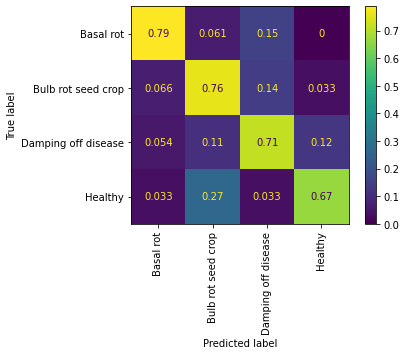

In [31]:
from sklearn import metrics

conf_matrix = metrics.confusion_matrix(all_labels.cpu().numpy(),predicted.cpu().numpy(),normalize='true')
cm_display = metrics.ConfusionMatrixDisplay(conf_matrix,display_labels=class_names)


cm_display.plot(xticks_rotation='vertical')
plt.show()

In [32]:
from sklearn.metrics import precision_recall_fscore_support,accuracy_score

print("Accuracy = ",accuracy_score(all_labels.cpu().numpy(),predicted.cpu().numpy()))

Accuracy =  0.7380952380952381
